<a href="https://colab.research.google.com/github/Xiar-fatah/Stock-Market-Patterns/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import data
from sklearn.preprocessing import MinMaxScaler


In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,batch_size):
        super(LSTM, self).__init__()
        """
        
        input_size: The number of expected features in the input "x", in our case it is 1,
        the opening price.
        
        hidden_size: The number of features in the hidden state "h"
        
        num_layers: Number of recurrent layers. E.g., setting "num_layers=2"
            would mean stacking two LSTMs together to form a "stacked LSTM",
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
            
        more explanation
            
        """
        self.input_size = input_size #1 
        self.hidden_size = hidden_size #trial and error
        self.num_layers = num_layers #is a number between 1 and 3
        self.output_size = output_size #1
        self.batch_size = batch_size #60
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def hidden_cell(self):
        """
        h_0 of shape (num_layers * num_directions, batch, hidden_size):
        tensor containing the initial hidden state for each element in the batch.
        If the LSTM is bidirectional, num_directions should be 2, else it should be 1.

        c_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial cell state for each element in the batch.
        
        If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
        """
        h_0,c_0 = (torch.zeros(1,self.batch_size,self.hidden_size), 
        torch.zeros(1,self.batch_size,self.hidden_size))
        return h_0,c_0 
    def forward(self, t):
        """
        output of shape (seq_len, batch, num_directions * hidden_size): 
        tensor containing the output features (h_t) from the last layer of the LSTM, for each t. 
        
        h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
                
        c_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the cell state for t = seq_len.
        """
        #Reshape the input tensor to satisfy (seq_len, batch, input_size)
        t = t.view(len(t),1, -1)
        t, (h_n,c_n) = self.lstm(t, (self.hidden_cell()))
        t = t.view(-1, self.hidden_size)
        t = self.linear(t)
        t = t[-1] #Last value is the value we are looking for, why?

        

        return t
        



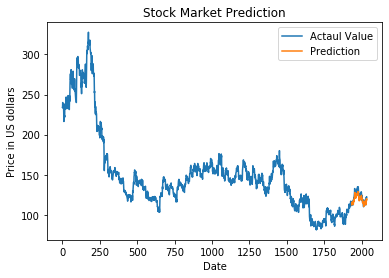

In [0]:
if __name__ == "__main__":
    
    model = LSTM(input_size = 1, hidden_size = 100,
                 num_layers = 1, output_size = 1, batch_size = 1)
    learning_rate = 0.001

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    epochs = 50

    for epoch in range(epochs):
        running_loss = 0.0
        for seq, labels in data.train_data:
            optimizer.zero_grad()
            output = model(seq)
            loss = loss_function(output, torch.Tensor([labels]))
            loss.backward()
            optimizer.step()

    model.eval()
    predictions = []
    with torch.no_grad():
        correct = 0
        total = 0
        for seq, labels in data.test_data:
            output = model(seq)
            predictions.append(output.item())

    predictions = np.array(predictions)
    predictions = data.sc.inverse_transform((predictions).reshape(-1, 1))
    
    trained_val = np.linspace(0,len(data.dataset)-1,len(data.dataset))
    test_val = np.linspace(len(data.dataset)-100,len(data.dataset),100) # np.linspace(1975,2034,100)

    plt.show()
    plt.figure()
    plt.plot(trained_val,data.dataset,
             test_val, predictions)
    plt.xlabel("Date")
    plt.ylabel("Price in US dollars")
    plt.title("Stock Market Prediction")
    plt.legend(("Actaul Value", "Prediction"))

    predictions = predictions.flatten()
    predictions = predictions.tolist()

    data = data.dataset.flatten()
    data = data.tolist()

    fig = go.Figure()
    fig.add_trace(go.Scatter(
                    x = trained_val,
                    y = data,
                    name="Actaul Value",
                    line_color='deepskyblue',
                    opacity=0.8))

    fig.add_trace(go.Scatter(
                    x = test_val,
                    y = predictions,
                    name="Predictions",
                    line_color='dimgray',
                    opacity=0.8))
    fig.update_layout(title_text='Tata Global Beverages Stock Prediction',
                      xaxis_rangeslider_visible=True,
                      xaxis_title='Time',
                      yaxis_title='US Dollars')

    fig.show()

    
        
        

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
